### Load the Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


### Load the Data - cleaned data after Data Preprocessing

In [112]:
df_cleaned = pd.read_csv("../data/processed/data.csv")

In [113]:
# Copy the cleaned data
df_search = df_cleaned.copy()

In [114]:
df_search.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,city_encoded,state_encoded
0,for_sale,105000.0,3,2,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,62,40
1,for_sale,80000.0,4,2,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,62,40
2,for_sale,67000.0,2,1,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,7367,40
3,for_sale,145000.0,4,2,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,11985,40
4,for_sale,179000.0,4,3,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,13281,40


### Generate queries

In [115]:
# Define simulated queries
queries = [
    {'city': 'Orlando', 'min_bed': 3, 'max_price': 500000},
    {'state': 'Florida', 'min_bath': 2, 'max_price': 600000},
    {'city': 'San Juan', 'min_house_size': 1500},
    {'state': 'Texas', 'max_price': 400000},
    {'city': 'Ponce', 'min_bed': 4, 'min_bath': 3, 'max_price': 750000},
    {'city': 'Olathe', 'min_bed': 3, 'min_bath': 2, 'min_house_size': 1800,'max_price': 350000},
    {'city': 'Austin', 'min_bed': 3, 'max_price': 500000},
    {'state': 'Texas', 'min_bath': 2},
    {'city': 'Orlando', 'max_price': 350000},
    {'state': 'Florida', 'min_house_size': 1200},
    {'city': 'San Juan', 'min_bed': 2, 'max_price': 400000}
]

# Store results
all_rows = []

for q in queries:
    # Filter for relevant listings
    relevant = df_search.copy()

    if 'city' in q:
        relevant = relevant[relevant['city'].str.lower() == q['city'].lower()]
    if 'state' in q:
        relevant = relevant[relevant['state'].str.lower() == q['state'].lower()]
    if 'min_bed' in q:
        relevant = relevant[relevant['bed'] >= q['min_bed']]
    if 'min_bath' in q:
        relevant = relevant[relevant['bath'] >= q['min_bath']]
    if 'min_house_size' in q:
        relevant = relevant[relevant['house_size'] >= q['min_house_size']]
    if 'max_price' in q:
        relevant = relevant[relevant['price'] <= q['max_price']]

    relevant = relevant.copy()
    relevant['relevance'] = 1
    relevant['query'] = str(q)

    # Get irrelevant samples
    irrelevant = df_search[~df_search.index.isin(relevant.index)].sample(n=min(300, len(df_search)), random_state=42)
    irrelevant = irrelevant.copy()
    irrelevant['relevance'] = 0
    irrelevant['query'] = str(q)

    all_rows.append(relevant)
    all_rows.append(irrelevant)




In [116]:
# Combine all query examples
query_df = pd.concat(all_rows, ignore_index=True)
print(f"Total simulated examples: {query_df.shape}")
query_df[['query', 'city', 'state', 'bed', 'bath', 'price', 'relevance']].head()

Total simulated examples: (428227, 14)


,query,city,state,bed,bath,price,relevance
0,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...",Orlando,Florida,3,2,330000.0,1
1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...",Orlando,Florida,3,2,433000.0,1
2,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...",Orlando,Florida,3,2,500000.0,1
3,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...",Orlando,Florida,3,3,429900.0,1
4,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...",Orlando,Florida,3,1,399900.0,1


In [117]:
query_df.shape

(428227, 14)

In [118]:
# Make a copy to work on
query_data = query_df.copy()

# string query column into dict
query_data['query_dict'] = query_data['query'].apply(ast.literal_eval)

In [119]:
query_data.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,city_encoded,state_encoded,relevance,query,query_dict
0,for_sale,330000.0,3,2,Orlando,Florida,32803.0,1893.0,NaN,7840.8,11143,9,1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...","{'city': 'Orlando', 'min_bed': 3, 'max_price':..."
1,for_sale,433000.0,3,2,Orlando,Florida,32803.0,1397.0,1999-09-03,7840.8,11143,9,1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...","{'city': 'Orlando', 'min_bed': 3, 'max_price':..."
2,for_sale,500000.0,3,2,Orlando,Florida,32803.0,1350.0,NaN,12632.4,11143,9,1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...","{'city': 'Orlando', 'min_bed': 3, 'max_price':..."
3,for_sale,429900.0,3,3,Orlando,Florida,32803.0,1974.0,2003-01-22,3484.8,11143,9,1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...","{'city': 'Orlando', 'min_bed': 3, 'max_price':..."
4,for_sale,399900.0,3,1,Orlando,Florida,32803.0,1416.0,2016-06-28,7840.8,11143,9,1,"{'city': 'Orlando', 'min_bed': 3, 'max_price':...","{'city': 'Orlando', 'min_bed': 3, 'max_price':..."


In [120]:
# Extract fields
query_data['query_min_bed'] = query_data['query_dict'].apply(lambda x: x.get('min_bed', np.nan))
query_data['query_max_price'] = query_data['query_dict'].apply(lambda x: x.get('max_price', np.nan))
query_data['query_min_bath'] = query_data['query_dict'].apply(lambda x: x.get('min_bath', np.nan))
query_data['query_min_house_size'] = query_data['query_dict'].apply(lambda x: x.get('min_house_size', np.nan))
query_data['query_city'] = query_data['query_dict'].apply(lambda x: x.get('city', np.nan))
query_data['query_state'] = query_data['query_dict'].apply(lambda x: x.get('state', np.nan))

# Convert city/state to categorical encoding for modeling

le_query_city = LabelEncoder()
le_query_state = LabelEncoder()

query_data['query_city_encoded'] = le_query_city.fit_transform(query_data['query_city'].astype(str))
query_data['query_state_encoded'] = le_query_state.fit_transform(query_data['query_state'].astype(str))

# Drop the original query columns if needed
query_data.drop(['query_dict', 'query'], axis=1, inplace=True)

# Quick check
query_data[['query_min_bed', 'query_max_price', 'query_city_encoded', 'query_state_encoded', 'relevance']].head()


,query_min_bed,query_max_price,query_city_encoded,query_state_encoded,relevance
0,3.0,500000.0,2,2,1
1,3.0,500000.0,2,2,1
2,3.0,500000.0,2,2,1
3,3.0,500000.0,2,2,1
4,3.0,500000.0,2,2,1


In [121]:
query_data.columns

Index(['status', 'price', 'bed', 'bath', 'city', 'state', 'zip_code',
       'house_size', 'prev_sold_date', 'lot_sqft', 'city_encoded',
       'state_encoded', 'relevance', 'query_min_bed', 'query_max_price',
       'query_min_bath', 'query_min_house_size', 'query_city', 'query_state',
       'query_city_encoded', 'query_state_encoded'],
      dtype='object')

### Features for X and y

In [122]:


# Features: listing features + query features
feature_cols = [
    'bed', 'bath', 'house_size', 'lot_sqft', 'price',
    'query_min_bed', 'query_min_bath', 'query_min_house_size', 'query_max_price',
    'query_city_encoded', 'query_state_encoded'
]

X = query_data[feature_cols]
y = query_data['relevance']


### Split 

train/test 0.2

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Fit Model



In [124]:


model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)


/Users/birukzewdie/Desktop/Work_interview/Machine_Learning_Projects/real-estate-search-ranking/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:38:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### Prediction and Evaluation

In [125]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

           0       0.91      0.58      0.71       660
           1       1.00      1.00      1.00     84986

    accuracy                           1.00     85646
   macro avg       0.95      0.79      0.85     85646
weighted avg       1.00      1.00      1.00     85646

AUC: 0.9198


### Ranking Model



In [126]:
# Restore query ID or string before the split
query_data = query_data.reset_index(drop=True)
X = query_data[feature_cols]
y = query_data['relevance']
query_ids = query_data['query_city_encoded'].astype(str) + "-" + query_data['query_state_encoded'].astype(str)


In [127]:
query_data

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,...,state_encoded,relevance,query_min_bed,query_max_price,query_min_bath,query_min_house_size,query_city,query_state,query_city_encoded,query_state_encoded
0,for_sale,330000.0,3,2,Orlando,Florida,32803.0,1893.0,NaN,7840.8,...,9,1,3.0,500000.0,NaN,NaN,Orlando,NaN,2,2
1,for_sale,433000.0,3,2,Orlando,Florida,32803.0,1397.0,1999-09-03,7840.8,...,9,1,3.0,500000.0,NaN,NaN,Orlando,NaN,2,2
2,for_sale,500000.0,3,2,Orlando,Florida,32803.0,1350.0,NaN,12632.4,...,9,1,3.0,500000.0,NaN,NaN,Orlando,NaN,2,2
3,for_sale,429900.0,3,3,Orlando,Florida,32803.0,1974.0,2003-01-22,3484.8,...,9,1,3.0,500000.0,NaN,NaN,Orlando,NaN,2,2
4,for_sale,399900.0,3,1,Orlando,Florida,32803.0,1416.0,2016-06-28,7840.8,...,9,1,3.0,500000.0,NaN,NaN,Orlando,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428222,for_sale,47500.0,3,2,Elmira,New York,14904.0,1176.0,2002-05-31,7405.2,...,33,0,2.0,400000.0,NaN,NaN,San Juan,NaN,4,2
428223,sold,99900.0,3,1,Waterford,Pennsylvania,16441.0,1040.0,2022-03-25,17424.0,...,39,0,2.0,400000.0,NaN,NaN,San Juan,NaN,4,2
428224,sold,229000.0,3,2,Arlington,Texas,76016.0,1594.0,2022-04-29,8276.4,...,45,0,2.0,400000.0,NaN,NaN,San Juan,NaN,4,2
428225,for_sale,225000.0,2,1,Satellite Beach,Florida,32937.0,820.0,NaN,2178.0,...,9,0,2.0,400000.0,NaN,NaN,San Juan,NaN,4,2


In [128]:

# Split again using same indices
X_train, X_test, y_train, y_test, query_train, query_test = train_test_split(
    X, y, query_ids, test_size=0.2, random_state=42, stratify=y
)


In [129]:
results_df = X_test.copy()
results_df['query'] = query_test
results_df['true_relevance'] = y_test.values
results_df['pred_proba'] = y_proba



In [130]:
results_df['query_id'] = query_test.values  # this should be "0-2", "3-0", etc.


In [131]:

def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.

def ndcg_at_k(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order)
    dcg_max = dcg_at_k(sorted(y_true, reverse=True), k)
    if dcg_max == 0:
        return 0.0
    return dcg_at_k(y_true_sorted, k) / dcg_max

def precision_at_k(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.take(y_true, order)
    return np.mean(y_true_sorted[:k])


In [132]:
grouped = results_df.groupby('query')
ndcg_scores = []
prec_scores = []

for query, group in grouped:
    if group['true_relevance'].sum() == 0:
        continue  # skip if no relevant docs
    ndcg = ndcg_at_k(group['true_relevance'].values, group['pred_proba'].values, k=5)
    prec = precision_at_k(group['true_relevance'].values, group['pred_proba'].values, k=5)
    ndcg_scores.append(ndcg)
    prec_scores.append(prec)

avg_ndcg = np.mean(ndcg_scores)
avg_prec = np.mean(prec_scores)

print(f"\nAverage NDCG@5: {avg_ndcg:.4f}")
print(f"Average Precision@5: {avg_prec:.4f}")



Average NDCG@5: 0.9435
Average Precision@5: 0.9667


In [133]:
query_scores = []

for query_id, group in results_df.groupby('query_id'):
    if group['true_relevance'].sum() == 0:
        continue
    ndcg = ndcg_at_k(group['true_relevance'].values, group['pred_proba'].values, k=5)
    query_scores.append({'query_id': query_id, 'ndcg@5': ndcg})

query_score_df = pd.DataFrame(query_scores)




In [134]:
query_score_df

,query_id,ndcg@5
0,0-2,0.66084
1,1-2,1.00000
2,2-2,1.00000
3,4-2,1.00000
4,5-0,1.00000
5,5-1,1.00000


In [135]:
# Get the unique combinations of query_city_encoded and query_state_encoded
query_info = query_data[['query_city_encoded', 'query_state_encoded', 'query_min_bed', 'query_max_price', 'query_min_bath', 'query_min_house_size']].copy()
query_info['query_id'] = query_info['query_city_encoded'].astype(str) + "-" + query_info['query_state_encoded'].astype(str)


In [136]:
query_info

,query_city_encoded,query_state_encoded,query_min_bed,query_max_price,query_min_bath,query_min_house_size,query_id
0,2,2,3.0,500000.0,NaN,NaN,2-2
1,2,2,3.0,500000.0,NaN,NaN,2-2
2,2,2,3.0,500000.0,NaN,NaN,2-2
3,2,2,3.0,500000.0,NaN,NaN,2-2
4,2,2,3.0,500000.0,NaN,NaN,2-2
...,...,...,...,...,...,...,...
428222,4,2,2.0,400000.0,NaN,NaN,4-2
428223,4,2,2.0,400000.0,NaN,NaN,4-2
428224,4,2,2.0,400000.0,NaN,NaN,4-2
428225,4,2,2.0,400000.0,NaN,NaN,4-2


In [137]:
# Drop duplicates to get one row per query
query_info = query_info.drop_duplicates('query_id')

In [138]:

# Create readable labels
def readable_query(row):
    parts = []
    if not pd.isna(row['query_min_bed']):
        parts.append(f"{int(row['query_min_bed'])}+ beds")
    if not pd.isna(row['query_min_bath']):
        parts.append(f"{int(row['query_min_bath'])}+ baths")
    if not pd.isna(row['query_min_house_size']):
        parts.append(f"{int(row['query_min_house_size'])}+ sqft")
    if not pd.isna(row['query_max_price']):
        parts.append(f"under ${int(row['query_max_price']):,}")
    return ', '.join(parts)

query_info['readable_query'] = query_info.apply(readable_query, axis=1)




/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_40872/2724117123.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_info['readable_query'] = query_info.apply(readable_query, axis=1)


In [141]:
query_score_df = query_score_df.merge(
    query_info[['query_id', 'readable_query']],
    on='query_id',
    how='left'
)


In [142]:
query_score_df

,query_id,ndcg@5,readable_query
0,0-2,0.66084,"3+ beds, under $500,000"
1,1-2,1.00000,"3+ beds, 2+ baths, 1800+ sqft, under $350,000"
2,2-2,1.00000,"3+ beds, under $500,000"
3,4-2,1.00000,1500+ sqft
4,5-0,1.00000,"2+ baths, under $600,000"
5,5-1,1.00000,"under $400,000"


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_40872/1884229902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ndcg@5', y='readable_query', data=query_score_df, palette='viridis')


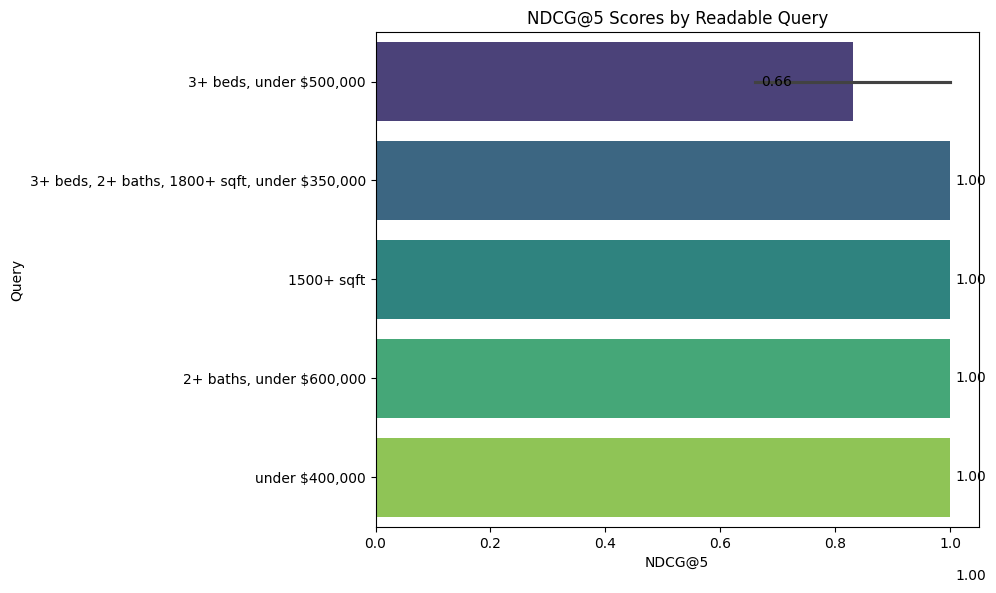

In [143]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ndcg@5', y='readable_query', data=query_score_df, palette='viridis')

# Add NDCG values as text
for i, (score, label) in enumerate(zip(query_score_df['ndcg@5'], query_score_df['readable_query'])):
    ax.text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=10, color='black')

plt.title('NDCG@5 Scores by Readable Query')
plt.xlabel('NDCG@5')
plt.ylabel('Query')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


In [144]:
query_score_df[['readable_query', 'ndcg@5']].sort_values(by='ndcg@5', ascending=False)


,readable_query,ndcg@5
1,"3+ beds, 2+ baths, 1800+ sqft, under $350,000",1.00000
2,"3+ beds, under $500,000",1.00000
3,1500+ sqft,1.00000
4,"2+ baths, under $600,000",1.00000
5,"under $400,000",1.00000
0,"3+ beds, under $500,000",0.66084


In [145]:
precision_scores = []

for query_id, group in results_df.groupby('query_id'):
    if group['true_relevance'].sum() == 0:
        continue
    prec = precision_at_k(group['true_relevance'].values, group['pred_proba'].values, k=5)
    precision_scores.append({'query_id': query_id, 'precision@5': prec})

precision_df = pd.DataFrame(precision_scores)


In [146]:
precision_df = precision_df.merge(
    query_info[['query_id', 'readable_query']],
    on='query_id',
    how='left'
)


In [147]:
precision_df

,query_id,precision@5,readable_query
0,0-2,0.8,"3+ beds, under $500,000"
1,1-2,1.0,"3+ beds, 2+ baths, 1800+ sqft, under $350,000"
2,2-2,1.0,"3+ beds, under $500,000"
3,4-2,1.0,1500+ sqft
4,5-0,1.0,"2+ baths, under $600,000"
5,5-1,1.0,"under $400,000"


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_40872/2322209659.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='precision@5', y='readable_query', data=precision_df, palette='coolwarm')


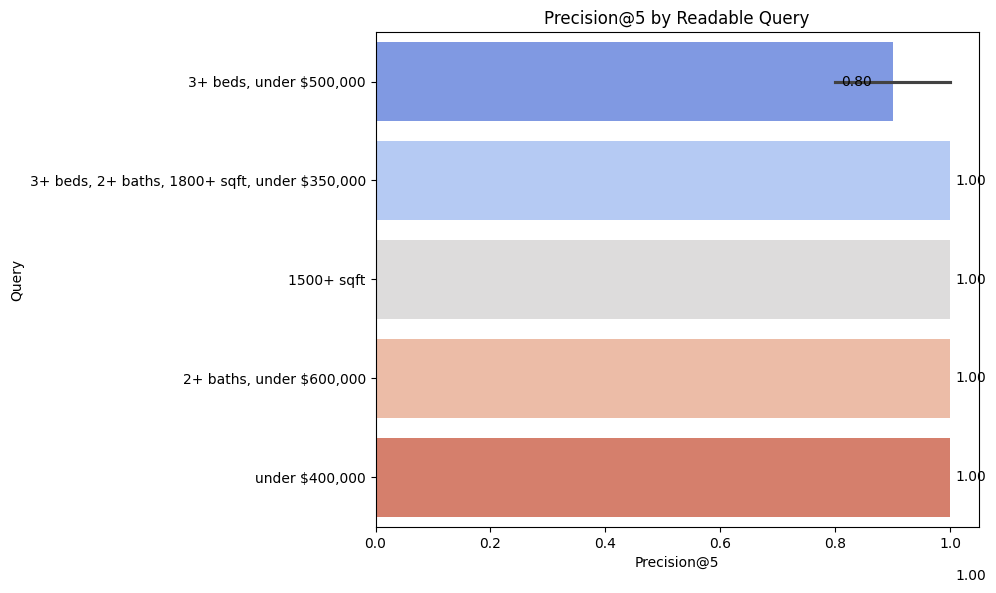

In [148]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='precision@5', y='readable_query', data=precision_df, palette='coolwarm')

# Add text labels
for i, (score, label) in enumerate(zip(precision_df['precision@5'], precision_df['readable_query'])):
    ax.text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=10, color='black')

plt.title('Precision@5 by Readable Query')
plt.xlabel('Precision@5')
plt.ylabel('Query')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


In [ ]:
path = "../data/processed/data.csv"

/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_40872/1785715207.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ndcg@5', y='readable_query', data=query_score_df, palette='viridis')


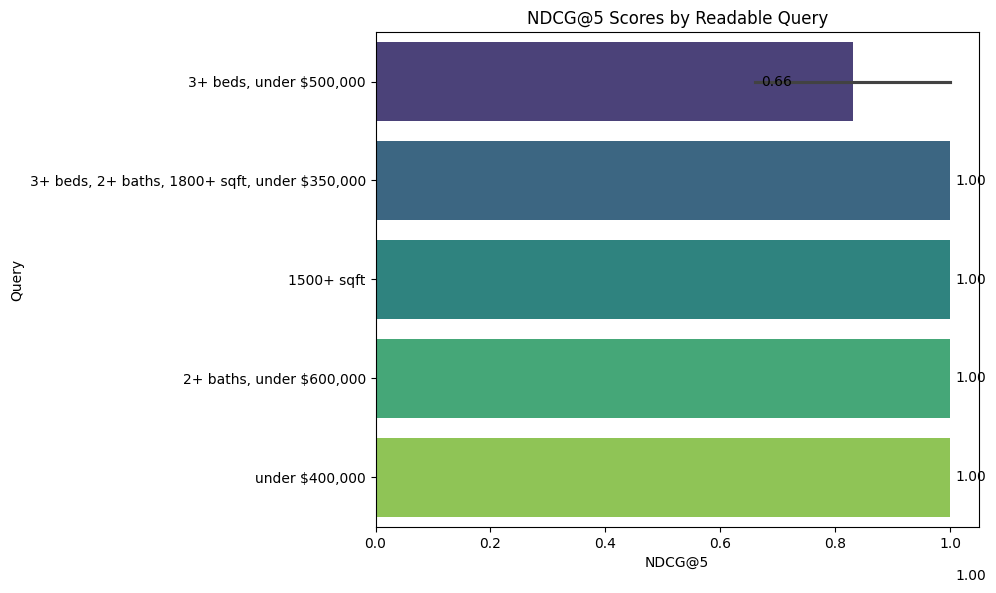

In [149]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ndcg@5', y='readable_query', data=query_score_df, palette='viridis')
for i, (score, label) in enumerate(zip(query_score_df['ndcg@5'], query_score_df['readable_query'])):
    ax.text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=10, color='black')

plt.title('NDCG@5 Scores by Readable Query')
plt.xlabel('NDCG@5')
plt.ylabel('Query')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig("../figures/ndcg_at_5_by_query.png", dpi=300)  # ← Save here
plt.show()


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_40872/931175311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='precision@5', y='readable_query', data=precision_df, palette='coolwarm')


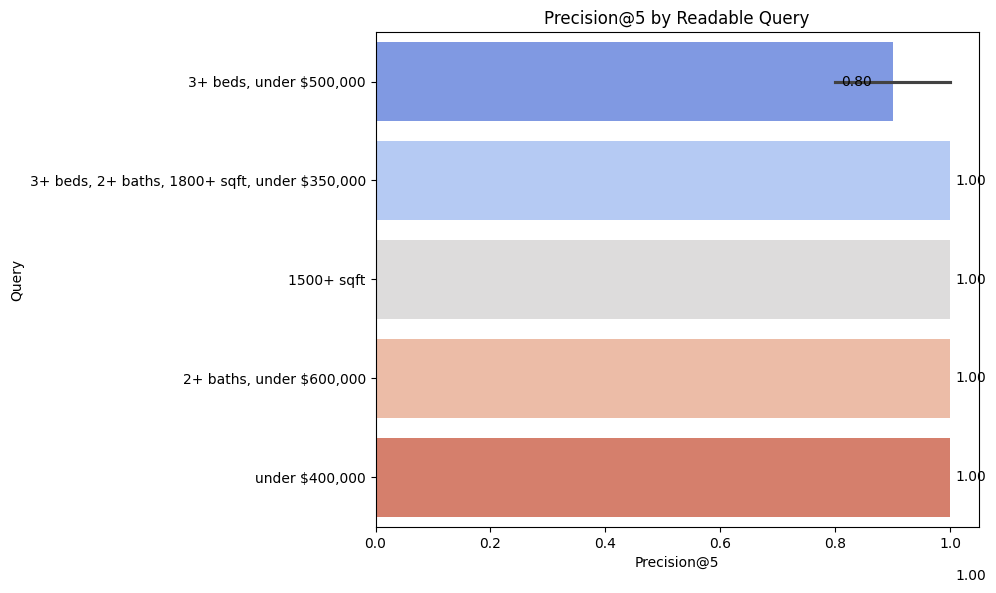

In [150]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='precision@5', y='readable_query', data=precision_df, palette='coolwarm')
for i, (score, label) in enumerate(zip(precision_df['precision@5'], precision_df['readable_query'])):
    ax.text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=10, color='black')

plt.title('Precision@5 by Readable Query')
plt.xlabel('Precision@5')
plt.ylabel('Query')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig("../figures/precision_at_5_by_query.png", dpi=300)  # ← Save here
plt.show()


In [151]:
print(f"Average NDCG@5: {query_score_df['ndcg@5'].mean():.4f}")
print(f"Average Precision@5: {precision_df['precision@5'].mean():.4f}")


Average NDCG@5: 0.9435
Average Precision@5: 0.9667
